## Lifecycle of data science projects
1. Data Collection Statergy
2. Feature Engineering

#### Different type of missing data
1. Missing Completely At Random,(MCAR) -> No relationship between variables. i.e there should be nothing like variable 
a is missing because variable b is missing.
2. Missing Data Not at random -> Missing Variables have relationship
2. Missing At Random -> means there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data i.e men will hide their salary and women hides their age.

In [68]:
%load_ext nb_black
import sys

sys.path.append("/Users/vikaspandey/my_projects/deeplearning_ai")
import pandas as pd

pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import datetime
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from data_visualisation.plot import Plot
from utils.utils import read_csv_in_pd
from utils.utils import get_or_drop_na_cols
from utils.utils import replace_categorical_nan_cols
from utils.utils import replace_numerical_nan_cols
from utils.utils import convert_categorical_to_one_hot_encoding
from utils.utils import get_cols_with_nan_values

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [69]:
train_data = read_csv_in_pd("titanic_dataset", "train.csv")

<IPython.core.display.Javascript object>

In [70]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<IPython.core.display.Javascript object>

In [71]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<IPython.core.display.Javascript object>

>1. In this case __age__ and __cabin__ have missing values but we cannot categories them as MCAR because missing Age value and cabin values are related.

>2. Embarked can be categoried as MCAR because it has no relationship with other variables.

In [72]:
train_data[train_data["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


<IPython.core.display.Javascript object>

>__Age__ and __group__ can be categorised as Missing Data Not at random

In [73]:
train_data["cabin_null"] = np.where(train_data["Cabin"].isnull(), 1, 0)
train_data["cabin_null"].mean()

0.7710437710437711

<IPython.core.display.Javascript object>

In [74]:
train_data.groupby(["Survived"])["cabin_null"].mean()

Survived
0    0.876138
1    0.602339
Name: cabin_null, dtype: float64

<IPython.core.display.Javascript object>

### Techniques of handling missing values
1. __Mean/Median/Mode replacement(Frequently used)__
    1. This should be applied when data is missing completely at random.
        - __Advantages__:
            1. Easy to implement
            2. Faster way to obtain complete dataset
        - __Disadvantages__:
            1. Change or distortion of the original varience
            2. Impacts Corelation
2. __Random sample imputation(Frequently used)__
    1. Take random sample from dataset and replace all nan values with that. It assumes that the data are missing completely at random.
        - __Advantages__
            1. Easy to implement
            2. Less distortion in the variance
        - __Disadvantages__
            1. Randomness doesn't always work
3. __Capturing NAN values with a new feature__
    - __Advantages__
        1. Easy to implement
        2. Captures the importance of the missing value
    - __Disadvantages__
        1. Creating additional Feature(Curse of dimentionality)
4. __End of distribution imputation__
    - __Advantages__
        1. Captures the importance of missingness if there is one.
        2. Easy to implement
    - __Disadvantages__
        1. Distorts the original distribution of the variables
5. __Arbitrary Imputation__
    1. Involves replacing nan from some arbitrary value
    2. The value must not be frequently present.
6. __Frequent Categories imputation__.
    1. Should not be used when there are more number of missing cols.
        - __Advantages__
            1. easy to implement
            2. faster way to implement
        - __Disadvantages__
            1. It distorts the relationship
            2. The most frequent value wil be over represented if there are more number of nans.
7. __Replace nans with some other value like 0 or 'missing'__.

In [75]:
trimmed_data = train_data[["Age", "Fare", "Survived"]]

<IPython.core.display.Javascript object>

In [76]:
trimmed_data.isnull().sum()

Age         177
Fare          0
Survived      0
dtype: int64

<IPython.core.display.Javascript object>

In [77]:
# Random Sample Imputation
random_sample = (
    trimmed_data["Age"]
    .dropna()
    .sample(trimmed_data["Age"].isnull().sum(), random_state=0)
)
trimmed_data.loc[:, "Age_random"] = trimmed_data["Age"].copy()
random_sample.index = trimmed_data[trimmed_data["Age"].isnull()].index
trimmed_data.loc[trimmed_data["Age"].isnull(), "Age_random"] = random_sample.copy()

<IPython.core.display.Javascript object>

In [78]:
# Capturing NAN values with a new feature
trimmed_data.loc[:, "Age_NA"] = np.where(trimmed_data["Age"].isnull(), 1, 0).copy()
trimmed_data["Age"].fillna(trimmed_data.Age.median(), inplace=True)

<IPython.core.display.Javascript object>

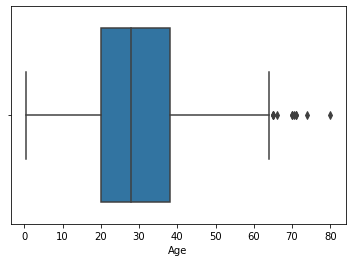

<IPython.core.display.Javascript object>

In [79]:
# End of distribution imputation
trimmed_data = train_data[["Age", "Fare", "Survived"]]
sns.boxplot("Age", data=trimmed_data)
extreme = trimmed_data.Age.mean() + 3 * trimmed_data.Age.std()
trimmed_data["Age_End_Of_Distribution"] = trimmed_data.Age.fillna(extreme)
trimmed_data.fillna(trimmed_data.Age.median(), inplace=True)

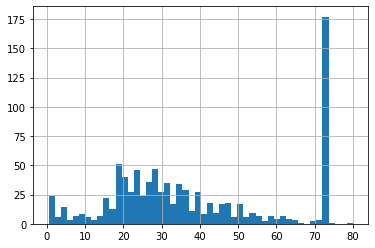

<IPython.core.display.Javascript object>

In [80]:
trimmed_data.Age_End_Of_Distribution.hist(bins=50)

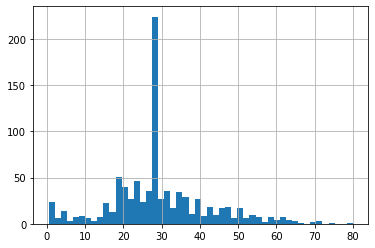

<IPython.core.display.Javascript object>

In [81]:
trimmed_data.Age.hist(bins=50)

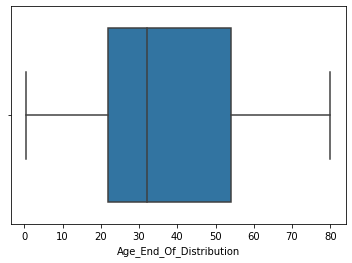

<IPython.core.display.Javascript object>

In [82]:
sns.boxplot("Age_End_Of_Distribution", data=trimmed_data)

In [83]:
# Arbitrary Value Imputation
trimmed_data = train_data[["Age", "Fare", "Survived"]]

<IPython.core.display.Javascript object>

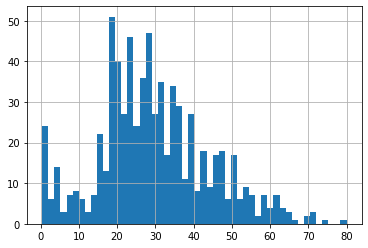

<IPython.core.display.Javascript object>

In [84]:
trimmed_data["Age"].hist(bins=50)

In [85]:
trimmed_data["Age_hundred"] = trimmed_data["Age"].fillna(100)

<IPython.core.display.Javascript object>

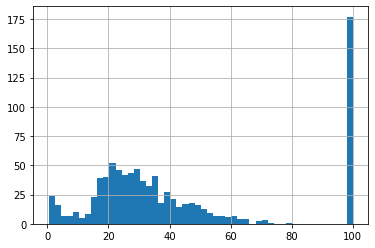

<IPython.core.display.Javascript object>

In [86]:
trimmed_data["Age_hundred"].hist(bins=50)

In [87]:
# Frequent Category Imputation
train_data = read_csv_in_pd("house-prices-advanced-regression-techniques", "train.csv")

<IPython.core.display.Javascript object>

In [88]:
df1 = train_data[["BsmtQual", "FireplaceQu", "GarageType", "SalePrice"]]

<IPython.core.display.Javascript object>

In [89]:
df1.head()

,BsmtQual,FireplaceQu,GarageType,SalePrice
0,Gd,NaN,Attchd,208500
1,Gd,TA,Attchd,181500
2,Gd,TA,Attchd,223500
3,TA,Gd,Detchd,140000
4,Gd,TA,Attchd,250000


<IPython.core.display.Javascript object>

In [90]:
df1.isnull().mean().sort_values(ascending=False)

FireplaceQu    0.472603
GarageType     0.055479
BsmtQual       0.025342
SalePrice      0.000000
dtype: float64

<IPython.core.display.Javascript object>

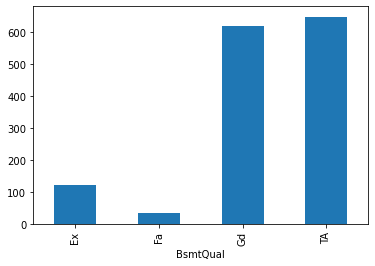

<IPython.core.display.Javascript object>

In [91]:
df1.groupby(["BsmtQual"])["BsmtQual"].count().plot.bar()

In [92]:
df1["GarageType"].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

<IPython.core.display.Javascript object>

In [93]:
def inpute_nan(df, variable):
    most_freq_category = df[variable].value_counts().index[0]
    df[variable].fillna(most_freq_category, inplace=True)

<IPython.core.display.Javascript object>

In [94]:
for feature in ["BsmtQual", "FireplaceQu", "GarageType"]:
    inpute_nan(df1, feature)

<IPython.core.display.Javascript object>

In [95]:
df1.isnull().mean()

BsmtQual       0.0
FireplaceQu    0.0
GarageType     0.0
SalePrice      0.0
dtype: float64

<IPython.core.display.Javascript object>

#### Handling Categorical Features

### 1. One Hot Encoding

In [96]:
train_data = read_csv_in_pd("titanic_dataset", "train.csv")
df = train_data["Sex"]
pd.get_dummies(df, drop_first=True).head()

,male
0,1
1,0
2,0
3,0
4,1


<IPython.core.display.Javascript object>

In [97]:
df = train_data["Embarked"]
df.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [98]:
pd.get_dummies(df, drop_first=True).head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


<IPython.core.display.Javascript object>

>__If there are n categories take n-1 categories__

### 2. One hot encoding with many categories in a feature
> __Take top most categorical features, one hot encode them and drop others__

In [100]:
mercedes_data = read_csv_in_pd("mercedes-benz-greener-manufacturing", "train.csv")

<IPython.core.display.Javascript object>

In [101]:
mercedes_data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [102]:
df = mercedes_data[["X0", "X1", "X2", "X3", "X4", "X5", "X6"]]

<IPython.core.display.Javascript object>

In [103]:
df.head()

,X0,X1,X2,X3,X4,X5,X6
0,k,v,at,a,d,u,j
1,k,t,av,e,d,y,l
2,az,w,n,c,d,x,j
3,az,t,n,f,d,x,l
4,az,v,n,f,d,h,d


<IPython.core.display.Javascript object>

In [104]:
df.X1.value_counts().sort_values(ascending=False).head(10)

aa    833
s     598
b     592
l     590
v     408
r     251
i     203
a     143
c     121
o      82
Name: X1, dtype: int64

<IPython.core.display.Javascript object>

In [105]:
indexes = df.X1.value_counts().sort_values(ascending=False).head(10).index

<IPython.core.display.Javascript object>

In [106]:
indexes

Index(['aa', 's', 'b', 'l', 'v', 'r', 'i', 'a', 'c', 'o'], dtype='object')

<IPython.core.display.Javascript object>

In [107]:
indexes = list(indexes)

<IPython.core.display.Javascript object>

In [108]:
for category in indexes:
    df[category] = np.where(df["X1"] == category, 1, 0)

<IPython.core.display.Javascript object>

In [109]:
df[indexes].head()

,aa,s,b,l,v,r,i,a,c,o
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


<IPython.core.display.Javascript object>

### 3. Ordinal Number System

In [110]:
today_date = datetime.datetime.today()

<IPython.core.display.Javascript object>

In [111]:
today_date

datetime.datetime(2020, 12, 21, 1, 18, 8, 402808)

<IPython.core.display.Javascript object>

In [112]:
days = [today_date - datetime.timedelta(x) for x in range(0, 15)]

In [113]:
data = pd.DataFrame(days)
data.columns = ["Day"]

<IPython.core.display.Javascript object>

In [114]:
data["weekday"] = data["Day"].dt.day_name()

<IPython.core.display.Javascript object>

In [115]:
d = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7,
}

<IPython.core.display.Javascript object>

In [116]:
data["weekday_ordinal"] = data["weekday"].map(d)

<IPython.core.display.Javascript object>

In [117]:
data

,Day,weekday,weekday_ordinal
0,2020-12-21 01:18:08.402808,Monday,1
1,2020-12-20 01:18:08.402808,Sunday,7
2,2020-12-19 01:18:08.402808,Saturday,6
3,2020-12-18 01:18:08.402808,Friday,5
4,2020-12-17 01:18:08.402808,Thursday,4
5,2020-12-16 01:18:08.402808,Wednesday,3
6,2020-12-15 01:18:08.402808,Tuesday,2
7,2020-12-14 01:18:08.402808,Monday,1
8,2020-12-13 01:18:08.402808,Sunday,7
9,2020-12-12 01:18:08.402808,Saturday,6


<IPython.core.display.Javascript object>

### 4. Count or Frequency Encoding

In [118]:
train_set = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    index_col=None,
)

<IPython.core.display.Javascript object>

In [119]:
columns = [1, 3, 5, 6, 7, 8, 9, 13]
train_set = train_set[columns]
train_set.columns = [
    "Employment",
    "Degree",
    "Status",
    "Designation",
    "family_job",
    "Race",
    "Sex",
    "Country",
]

<IPython.core.display.Javascript object>

In [120]:
train_set.head()

,Employment,Degree,Status,Designation,family_job,Race,Sex,Country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


<IPython.core.display.Javascript object>

In [121]:
for feature in train_set.columns:
    print(feature, ":", len(train_set[feature].unique()))

Employment : 9
Degree : 16
Status : 7
Designation : 15
family_job : 6
Race : 5
Sex : 2
Country : 42


<IPython.core.display.Javascript object>

In [122]:
country_map = train_set["Country"].value_counts().to_dict()

<IPython.core.display.Javascript object>

In [123]:
train_set["Country"] = train_set["Country"].map(country_map)

<IPython.core.display.Javascript object>

In [124]:
train_set.head(5)

,Employment,Degree,Status,Designation,family_job,Race,Sex,Country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,29170
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,29170
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,29170
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,29170
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,95


<IPython.core.display.Javascript object>

#### Advantages
    1. Ease of Use.
    2. Not increasing feature space
#### Disadvantages
    1. If the frequencies are same it will provide the same weight.

### 5. Target Guided ordinal encoding.
1. Ordering the labels according to the target
2. Replace the labels by joint probablity of being 0 or 1

In [125]:
titanic_data = read_csv_in_pd("titanic_dataset", "train.csv")

<IPython.core.display.Javascript object>

In [126]:
df = titanic_data[["Cabin", "Survived"]]

<IPython.core.display.Javascript object>

In [127]:
df.head()

,Cabin,Survived
0,NaN,0
1,C85,1
2,NaN,1
3,C123,1
4,NaN,0


<IPython.core.display.Javascript object>

In [128]:
df["Cabin"].fillna("Missing", inplace=True)

<IPython.core.display.Javascript object>

In [129]:
df.head()

,Cabin,Survived
0,Missing,0
1,C85,1
2,Missing,1
3,C123,1
4,Missing,0


<IPython.core.display.Javascript object>

In [130]:
df["Cabin"] = df["Cabin"].astype(str).str[0]

<IPython.core.display.Javascript object>

In [131]:
ordinal_labels = df.groupby(["Cabin"])["Survived"].mean().sort_values().index

<IPython.core.display.Javascript object>

In [132]:
map_dict = {
   k:i for i, k in enumerate(ordinal_labels, 0) 
}

In [133]:
df["Cabin_ordinal_labels"] = df["Cabin"].map(map_dict)

<IPython.core.display.Javascript object>

In [134]:
df.head()

,Cabin,Survived,Cabin_ordinal_labels
0,M,0,1
1,C,1,4
2,M,1,1
3,C,1,4
4,M,0,1


<IPython.core.display.Javascript object>

### 6. Mean Encoding

In [135]:
df = titanic_data[["Cabin", "Survived"]]
df["Cabin"].fillna("Missing", inplace=True)

<IPython.core.display.Javascript object>

In [136]:
df["Cabin"] = df["Cabin"].astype(str).str[0]

<IPython.core.display.Javascript object>

In [137]:
mean_dict1 = df.groupby(["Cabin"])["Survived"].mean().to_dict()

<IPython.core.display.Javascript object>

In [138]:
mean_dict1

{'A': 0.4666666666666667,
 'B': 0.7446808510638298,
 'C': 0.5932203389830508,
 'D': 0.7575757575757576,
 'E': 0.75,
 'F': 0.6153846153846154,
 'G': 0.5,
 'M': 0.29985443959243085,
 'T': 0.0}

<IPython.core.display.Javascript object>

In [139]:
df["mean_ordinal_encode"] = df["Cabin"].map(mean_dict1)

<IPython.core.display.Javascript object>

### 6. Probablity Ratio Encoding

In [140]:
prob_df = df.groupby("Cabin")["Survived"].mean()
prob_df = pd.DataFrame(prob_df)
prob_df.head()

,Survived
Cabin,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000


<IPython.core.display.Javascript object>

In [141]:
prob_df["Died"] = 1 - prob_df["Survived"]

<IPython.core.display.Javascript object>

In [142]:
prob_df["probablity_ratio"] = prob_df["Survived"] / prob_df["Died"]

<IPython.core.display.Javascript object>

In [143]:
prob_df.head()

,Survived,Died,probablity_ratio
Cabin,,,
A,0.466667,0.533333,0.875000
B,0.744681,0.255319,2.916667
C,0.593220,0.406780,1.458333
D,0.757576,0.242424,3.125000
E,0.750000,0.250000,3.000000


<IPython.core.display.Javascript object>

In [144]:
df["Cabin_encoded"] = df["Cabin"].map(prob_df["probablity_ratio"].to_dict())

<IPython.core.display.Javascript object>

In [145]:
df.head()

,Cabin,Survived,mean_ordinal_encode,Cabin_encoded
0,M,0,0.299854,0.428274
1,C,1,0.593220,1.458333
2,M,1,0.299854,0.428274
3,C,1,0.593220,1.458333
4,M,0,0.299854,0.428274


<IPython.core.display.Javascript object>

#### 1. Transformation Of Features
- __Why transformation of features are required__.
    - This is because the algorithms like gradient descent etc works well with smaller values.
    - Transformation is not required in all ML algorithms. Its very much reuired when you are working with Gradient descent, KNN, ANN, CNN, RNN etc

- __Types and Transformation__
    1. Normalization And Standarisation.
    2. Scaling to Minimum and Maxmium values.
    3. Scaling to Median and Quantiles.
    4. Guassian Transformation
        - Logarithmic Transformation
        - Reciprocal Transformation
        - Square Root Transformation
        - Exponential Transformation
        - Box Cox Transformation

##### 1. Normalization And Standarisation
- We try to bring all the variables or features to a similar scale. Standarisation means centering the variable at zero. Z = (X - X_mean)/std

In [146]:
df = titanic_data[["Pclass", "Age", "Fare", "Survived"]]
df.head()

,Pclass,Age,Fare,Survived
0,3,22.0,7.2500,0
1,1,38.0,71.2833,1
2,3,26.0,7.9250,1
3,1,35.0,53.1000,1
4,3,35.0,8.0500,0


<IPython.core.display.Javascript object>

In [147]:
df["Age"].fillna(df.Age.median(), inplace=True)

<IPython.core.display.Javascript object>

In [148]:
from sklearn.preprocessing import StandardScaler

<IPython.core.display.Javascript object>

In [155]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

<IPython.core.display.Javascript object>

In [156]:
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

(array([ 40.,  14.,  15.,  31.,  79.,  98., 262.,  84.,  73.,  45.,  35.,
         35.,  29.,  16.,  13.,  11.,   4.,   5.,   1.,   1.]),
 array([-2.22415608, -1.91837055, -1.61258503, -1.3067995 , -1.00101397,
        -0.69522845, -0.38944292, -0.08365739,  0.22212813,  0.52791366,
         0.83369919,  1.13948471,  1.44527024,  1.75105577,  2.05684129,
         2.36262682,  2.66841235,  2.97419787,  3.2799834 ,  3.58576892,
         3.89155445]),
 <a list of 20 Patch objects>)

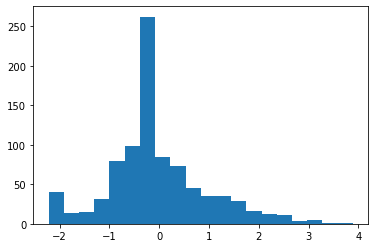

<IPython.core.display.Javascript object>

In [161]:
plt.hist(df_scaled[:, 1], bins=20)

#### 2. Min Max Scaling

> Min max Scaling scales the values between 0 to 1
X_scaled = (X - X.min)/(X.max - X.min)

In [163]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
df_minmax = pd.DataFrame(min_max.fit_transform(df), columns=df.columns)
df_minmax.head()

,Pclass,Age,Fare,Survived
0,1.0,0.271174,0.014151,0.0
1,0.0,0.472229,0.139136,1.0
2,1.0,0.321438,0.015469,1.0
3,0.0,0.434531,0.103644,1.0
4,1.0,0.434531,0.015713,0.0


<IPython.core.display.Javascript object>

##### 3. Robust Scaler
- It is used to scale the feature to median and quantiles.
- IQR = 75th quantile - 25th quantile. X_scaled = (X - X.median) / IQR


In [167]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df_robust_scaler = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_robust_scaler.head()

,Pclass,Age,Fare,Survived
0,0.0,-0.461538,-0.312011,0.0
1,-2.0,0.769231,2.461242,1.0
2,0.0,-0.153846,-0.282777,1.0
3,-2.0,0.538462,1.673732,1.0
4,0.0,0.538462,-0.277363,0.0


<IPython.core.display.Javascript object>

(array([562., 170.,  67.,  39.,  15.,  16.,   2.,   0.,   9.,   2.,   6.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([-0.62600478,  0.48343237,  1.59286952,  2.70230667,  3.81174382,
         4.92118096,  6.03061811,  7.14005526,  8.24949241,  9.35892956,
        10.46836671, 11.57780386, 12.68724101, 13.79667816, 14.90611531,
        16.01555246, 17.12498961, 18.23442675, 19.3438639 , 20.45330105,
        21.5627382 ]),
 <a list of 20 Patch objects>)

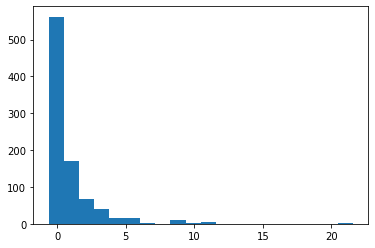

<IPython.core.display.Javascript object>

In [169]:
plt.hist(df_robust_scaler["Fare"], bins=20)

#### 4. Gaussian Transformation
- We transform the non normal data to normal data using this method. This is because some machine learning algorithms like linear and logistic regression assumes that features are normally distributed. 

##### 1. Logarithmic Transformation

In [171]:
df = titanic_data[["Pclass", "Age", "Fare", "Survived"]]
df.head()

,Pclass,Age,Fare,Survived
0,3,22.0,7.2500,0
1,1,38.0,71.2833,1
2,3,26.0,7.9250,1
3,1,35.0,53.1000,1
4,3,35.0,8.0500,0


<IPython.core.display.Javascript object>

In [187]:
import scipy.stats as stat
import pylab

<IPython.core.display.Javascript object>

In [188]:
df["Age"] = df["Age"].fillna(df["Age"].median())

<IPython.core.display.Javascript object>

##### If we want to check whether feature is guassian or normal distributed we use Q-Q plot.

In [189]:
def plot_data(df, feature):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stat.probplot(df[feature], dist="norm", plot=pylab)
    plt.show()

<IPython.core.display.Javascript object>

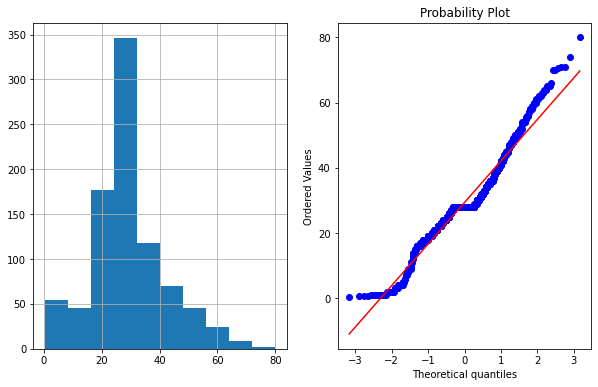

<IPython.core.display.Javascript object>

In [190]:
plot_data(df, "Age")

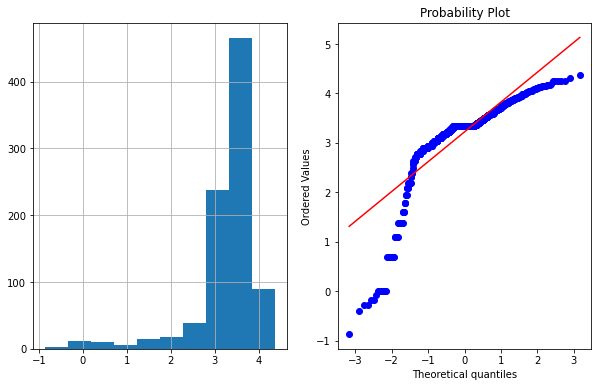

<IPython.core.display.Javascript object>

In [192]:
df["Age_log"] = np.log(df["Age"])
plot_data(df, "Age_log")

- In this case log transformation cannot be applied because its making the data left skewed.

In [195]:
### Reciprocal Transformation
df["age_reciprocal"] = 1.0 / df["Age"]

<IPython.core.display.Javascript object>

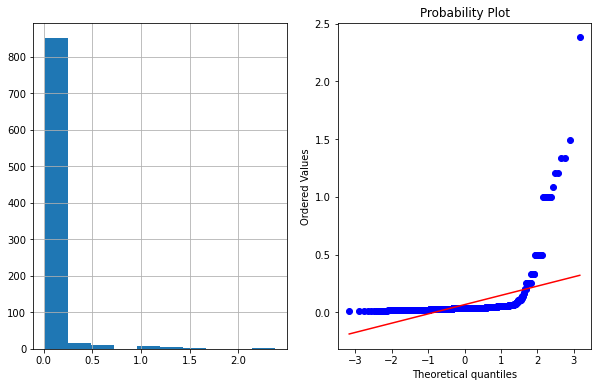

<IPython.core.display.Javascript object>

In [196]:
plot_data(df, "age_reciprocal")

In [198]:
### Square Root Transformation
df["age_sqr_transformation"] = df["Age"] ** 1 / 2

<IPython.core.display.Javascript object>

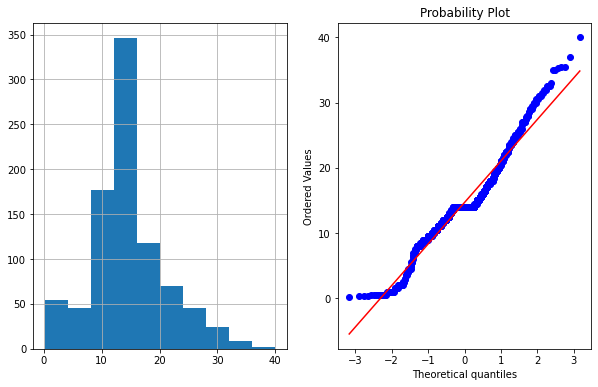

<IPython.core.display.Javascript object>

In [199]:
plot_data(df, "age_sqr_transformation")

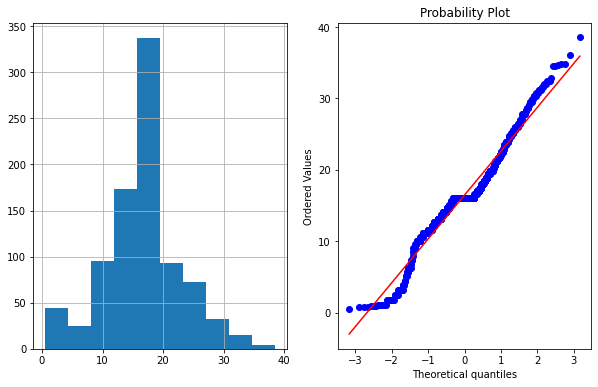

<IPython.core.display.Javascript object>

In [201]:
### Exponential Transformation
df["age_exponential"] = df.Age ** (1 / 1.2)
plot_data(df, "age_exponential")

In [205]:
#### Box-Cox transformation
df["Age_boxcox"], parameters = stat.boxcox(df["Age"])

<IPython.core.display.Javascript object>

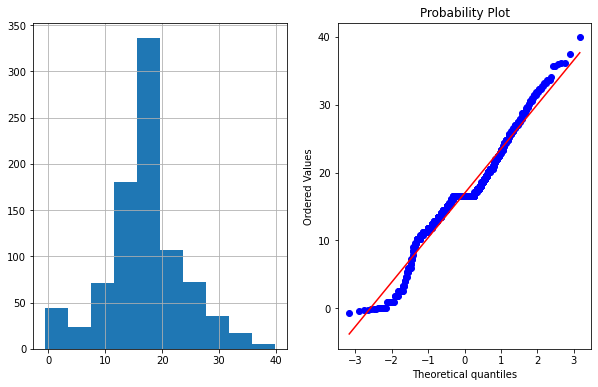

<IPython.core.display.Javascript object>

In [204]:
plot_data(df, "Age_boxcox")